## 2.1 Preprocess the raw data

Categorical features found in columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12]


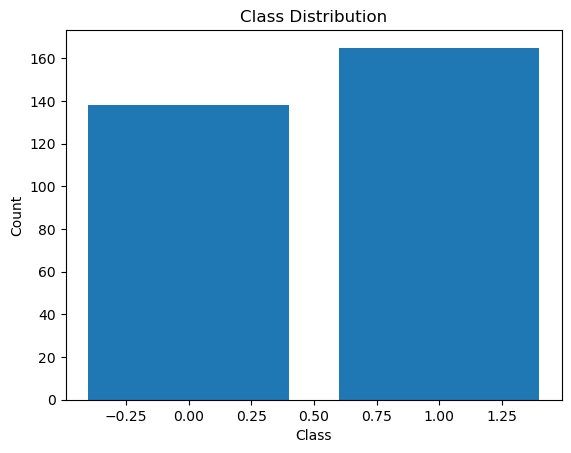

In [16]:
# Check whether there are missing values
# Check whether theare are cateogrical features
# Check whether this dataset is balanced or not (use the bar plot to visualize the number of positive and negative samples)

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from random import shuffle
import random
random.seed(123)

# Load dataset
data = np.genfromtxt('heart.csv', delimiter=',', skip_header=1, filling_values=np.nan)

# Handle missing values by removing rows with NaN
data = data[~np.isnan(data).any(axis=1)]

# Extract X and y from the data
X = data[:, :-1] 
y = data[:, -1]  

# Check for categorical features
categorical_features = []
for i in range(X.shape[1]):
    unique_values = np.unique(X[:, i])
    if np.all(np.mod(unique_values, 1) == 0):  # Check if all unique values are integers
        categorical_features.append(i)

if categorical_features:
    print("Categorical features found in columns:", categorical_features)
else:
    print("No categorical features found.")

# Check if the dataset is balanced
y = y.astype(int)
class_distribution = np.bincount(y)
plt.bar(np.unique(y), class_distribution)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()

## 2.2 Split the data into two subsets and normalize the features of samples

In [17]:
#Split the dataset into the train_val set and testing set.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                            test_size=0.12, 
                                                            random_state=0)
print("train_val: {}, test: {}".format(X_train_val.shape[0], X_test.shape[0]))

#Normalize features
normalizer = StandardScaler()
X_train_val = normalizer.fit_transform(X_train_val)
X_test = normalizer.transform(X_test)

train_val: 266, test: 37


## 2.3 Train the logistic regression model and select the hyperparameter with cross-validation

In [25]:
# here we use 10-fold cross-validation
folds = 10

# get the number of samples in the training and validation set
num_train_val = X_train_val.shape[0] 

# shuffle the index of samples in the train_val set
index_of_samples = np.arange(num_train_val) 
shuffle(index_of_samples)

# calculate the number of samples per fold and the remainder
samples_per_fold = num_train_val // folds
remainder = num_train_val % folds

# split the index of the train_valid set into 10 folds
index_of_folds = []
start = 0
for fold in range(folds):
    fold_size = samples_per_fold + 1 if fold < remainder else samples_per_fold
    end = start + fold_size
    index_of_folds.append(index_of_samples[start:end])
    start = end

print(index_of_folds)

# potential hyperparameters. 
#These hyperparameters are just used for illustration. 
#You should try more hyperparameters to get a good model.
#The hyperparameters must be nonnegative!
regularization_coefficient = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 50, 100]

best_acc = 0.0
best_reg = 0.0

for reg in regularization_coefficient:
    
    # 10-fold cross-validation
    sum_acc = 0.0
    for fold in range(folds):
        
        index_of_folds_temp = index_of_folds.copy()
        
        valid_index = index_of_folds_temp[fold].reshape(-1) #get the index of the validation set
        train_index = np.concatenate([index_of_folds_temp[i] for i in range(folds) if i != fold]) #get the index of the training set
        
        # training set
        X_train = X_train_val[train_index]
        y_train = y_train_val[train_index]
        
        # validation set
        X_valid = X_train_val[valid_index]
        y_valid = y_train_val[valid_index]
                
        # build the model with different hyperparameters
        clf = LogisticRegression(penalty='l2', C=reg, solver='lbfgs')
        
        #train the model with the training set
        clf.fit(X_train, y_train)
        
        y_valid_pred = clf.predict(X_valid)
        acc = accuracy_score(y_valid, y_valid_pred)
        
        sum_acc += acc
    
    cur_acc = sum_acc / folds
    
    print("reg_coeff: {}, acc: {:.3f}".format(1.0/reg, cur_acc))
    
    # store the best hyperparameter
    if cur_acc > best_acc:
        best_acc = cur_acc
        best_reg = reg

[array([ 42, 112,  75,  28, 188,  76, 245, 241, 113, 260, 103,  36, 201,
       214, 208, 164, 199,  51, 215, 124,  95, 107,  98,  53, 174, 225,
       219]), array([247,  81,  39,  37, 222, 177,  87,  60, 183, 121,  64, 135, 233,
        71,  59, 244, 189,  38, 246, 168, 165, 254,  12,  49,  24, 251,
       226]), array([ 40, 115, 110,  58,   3, 162,  26,  33,  52, 249,  19, 118, 163,
         2, 187,  84, 119, 172, 261, 250, 160,  54, 206, 182, 234,  23,
       248]), array([205,  61, 100, 236, 257, 184, 129, 217,  96, 203,   0,  88, 148,
         5, 102,  20, 252, 114, 259, 207, 157,  22, 144, 242, 152,   6,
       111]), array([181, 116, 197, 190,   9, 180, 255, 109, 154, 101, 229, 175,  90,
       193,  80, 178, 173, 212, 128, 134, 194,  31,  30, 151,  70,  17,
       141]), array([ 74,  35,  97, 243,  14, 125, 145, 240, 108,  89, 126, 220,  57,
       235, 143, 211, 224, 120,  63, 263, 131, 191,  65,  83,  45, 149,
       171]), array([ 29, 202, 153, 170, 227,  82,  94, 216, 265,

## 2.4 Evaluate the learned model

accuracy: 0.757, recall: 0.882, precision: 0.682, f1: 0.769,


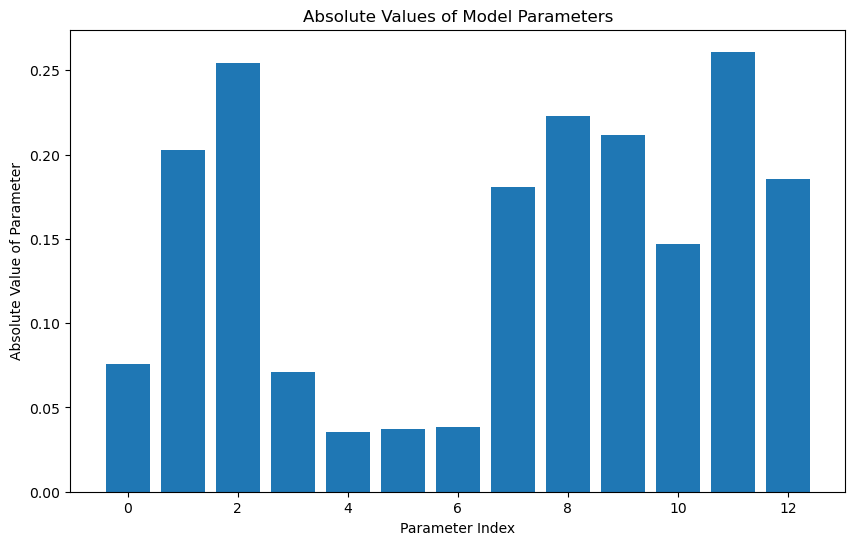

In [42]:
# retrain the model
clf = LogisticRegression(penalty='l2', C=best_reg, solver='lbfgs')
clf.fit(X_train_val, y_train_val)

# evaluate the model on the testing set
y_test_pred = clf.predict(X_test)


acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)


print("accuracy: {:.3f}, recall: {:.3f}, precision: {:.3f}, f1: {:.3f},".format(acc, recall, precision, f1))

#Use the bar plot to visulaize the elements of the learned model parameter vector w. Some elements have larger absolute values, while the others do not. Try to explain this phenomenon.
w = clf.coef_[0]

# Plot the absolute values of the model parameters
plt.figure(figsize=(10, 6))
plt.bar(range(len(w)), abs(w))
plt.xlabel('Parameter Index')
plt.ylabel('Absolute Value of Parameter')
plt.title('Absolute Values of Model Parameters')
plt.show()